In [3]:
!pip install category_encoders==2.*
!pip install pdpbox
!pip install shap

     |████████████████████████████████| 80 kB 5.6 MB/s 
     |████████████████████████████████| 34.0 MB 36 kB/s 
     |████████████████████████████████| 13.1 MB 6.5 kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758225 sha256=a1dd0d549d8670d7a95817942e9488a9a151db70986da83239bf9b5c615c7fc0
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built pdpbox
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 356 kB 8.2 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491658 sha256=fa13ddf7aa304885ed795b477e27021b63a3996227f07dc29a6d3ef504138b40
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [4]:
# import libraries
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

# encoders
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

#metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_auc_score, mean_absolute_error

#pipeline
from sklearn.pipeline import make_pipeline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from IPython.display import Image
from IPython.core.display import HTML 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
filepath = 'pollution_us_2000_2016.csv.zip'

In [10]:
def wrangle(filepath):
  df = pd.read_csv(filepath, parse_dates= ['Date Local']).set_index('Date Local')

  #AQI is calculated as the sum of all averages of pollutants
  df['total_AQI'] = df['NO2 Mean'] + df['O3 Mean'] + df['SO2 Mean'] + df['CO Mean']
  df['total_AQI'] = round(df['total_AQI'])


  #generating binary classifier for target, good AQI is less than 50. 1 for good 
  df['Good_AQI'] = (df['total_AQI'] <= 50).astype(int)

  #Dropping columns that aren't useful for prediction model
  variance = ['Address', 'Unnamed: 0', 'Site Num']
  df.drop(columns = variance, inplace = True)

  #dropping object variables and creating subset of object variables to be merged after fitting model
  object_drop = ['State', 'County', 'City', 'NO2 Units', 'O3 Units', 'SO2 Units', 'CO Units']
  df.drop(columns= object_drop, inplace=True)

  #dropping any observations with NaN
  df.dropna(inplace=True)

  return df

In [11]:
df = wrangle(filepath)

In [ ]:
df.shape

(436876, 20)

In [13]:
df.head()


,State Code,County Code,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI,total_AQI,Good_AQI
Date Local,,,,,,,,,,,,,,,,,,,,
2000-01-01,4,13,19.041667,49.0,19,46,0.022500,0.040,10,34,3.000000,9.0,21,13.0,0.878947,2.2,23,25.0,23.0,1
2000-01-02,4,13,22.958333,36.0,19,34,0.013375,0.032,10,27,1.958333,3.0,22,4.0,1.066667,2.3,0,26.0,26.0,1
2000-01-03,4,13,38.125000,51.0,8,48,0.007958,0.016,9,14,5.250000,11.0,19,16.0,1.762500,2.5,8,28.0,45.0,1
2000-01-04,4,13,40.260870,74.0,8,72,0.014167,0.033,9,28,7.083333,16.0,8,23.0,1.829167,3.0,23,34.0,49.0,1
2000-01-05,4,13,48.450000,61.0,22,58,0.006667,0.012,9,10,8.708333,15.0,7,21.0,2.700000,3.7,2,42.0,60.0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 436876 entries, 2000-01-01 to 2016-03-31
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   State Code         436876 non-null  int64  
 1   County Code        436876 non-null  int64  
 2   NO2 Mean           436876 non-null  float64
 3   NO2 1st Max Value  436876 non-null  float64
 4   NO2 1st Max Hour   436876 non-null  int64  
 5   NO2 AQI            436876 non-null  int64  
 6   O3 Mean            436876 non-null  float64
 7   O3 1st Max Value   436876 non-null  float64
 8   O3 1st Max Hour    436876 non-null  int64  
 9   O3 AQI             436876 non-null  int64  
 10  SO2 Mean           436876 non-null  float64
 11  SO2 1st Max Value  436876 non-null  float64
 12  SO2 1st Max Hour   436876 non-null  int64  
 13  SO2 AQI            436876 non-null  float64
 14  CO Mean            436876 non-null  float64
 15  CO 1st Max Value   436876 non-null 

In [14]:
target = 'total_AQI'
#feature matrix
X = df.drop(columns = target)
#target vector
y = df[target]

In [15]:
#train and test split data ;  
cutoff = 2016
mask = X.index.year < cutoff

X_train, y_train = X.loc[mask], y.loc[mask]
X_val, y_val = X.loc[~mask], y.loc[~mask]

In [ ]:
X_val.shape

(6154, 19)

In [ ]:
X_train.shape

(430722, 19)

ESTABLISH BASELINE


In [16]:
y_pred = [y_train.mean()]* len(y_train)
print('Mean AQI', y_train.mean())
print('Baseline MAE', mean_absolute_error(y_train, y_pred))

Mean AQI 15.155696713889702
Baseline MAE 8.511289898480218


Build Model

In [17]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [18]:
#pipeline model building , Ridge, random forest and XGB

model_r = Ridge()
model_rf = RandomForestRegressor()
model_xgbr = XGBRegressor()

In [19]:
#fitting models
model_r.fit(X_train,y_train)
model_rf.fit(X_train,y_train)
model_xgbr.fit(X_train,y_train)

[22:39:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


KeyboardInterrupt: ignored

Check Metrics

In [ ]:


for model in [model_r,model_rf,model_xgbr]:
  print(type(model))
  print('Training MAE:', mean_absolute_error(y_train,model.predict(X_train)))
  print('Validation MAE :', mean_absolute_error(y_val,model.predict(X_val)))
  print('R2 score:', model.score(X_val,y_val))
  print()

  #Random forest Regressor has the smallest MAE and highest R2

<class 'sklearn.linear_model._ridge.Ridge'>
Training MAE: 0.24988015731359126
Validation MAE : 0.2517636563766485
R2 score: 0.9987701946331453

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
Training MAE: 0.04047975260144598
Validation MAE : 0.07241793955151121
R2 score: 0.999591757202802

<class 'xgboost.sklearn.XGBRegressor'>
Training MAE: 0.3311585907080645
Validation MAE : 0.28263509168925516
R2 score: 0.9981376209859534



In [ ]:
#Hyperarameter tuning with Grid Search
#Run time was too long

# #defining our dictionary for parameter grid
# from sklearn.model_selection import RandomizedSearchCV

# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
                  

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# model_rf = RandomForestRegressor()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = model_rf,
#                                param_distributions = random_grid, 
#                                n_iter = 15, cv = 3, verbose=2, 
#                                random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(X_train, y_train)

In [ ]:
# best_score = model_rf.best_score_
# best_params = model_rf.best_params_

# print('Best score for model:', best_score)
# print('Best params for model:', best_params)

In [ ]:
#building permutation importance

from sklearn.inspection import permutation_importance
perm_imp = permutation_importance(model_rf, X_val,y_val,random_state=42)

In [ ]:
data_perm = {'imp_mean':perm_imp['importances_mean'],
             'imp_std':perm_imp['importances_std']}
df_perm = pd.DataFrame(data_perm, index=X_val.columns).sort_values('imp_mean')

In [ ]:
df_perm

,imp_mean,imp_std
NO2 1st Max Hour,-1.595786e-06,8.937493e-07
O3 1st Max Hour,-4.673275e-07,7.509239e-07
O3 AQI,2.817710e-07,9.157291e-08
O3 Mean,5.097946e-07,1.258428e-06
SO2 AQI,6.566757e-07,5.708931e-07
State Code,8.511901e-07,4.727523e-07
O3 1st Max Value,1.302687e-06,1.930810e-07
County Code,1.346624e-06,1.252498e-06
CO 1st Max Hour,1.429615e-06,8.296670e-07
SO2 1st Max Hour,1.670103e-06,5.395618e-07


Communicate results

In [23]:
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap
pd.options.display.max_rows = 200

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


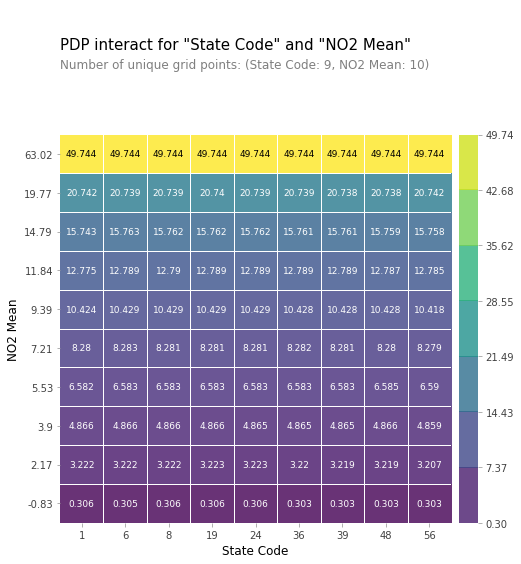

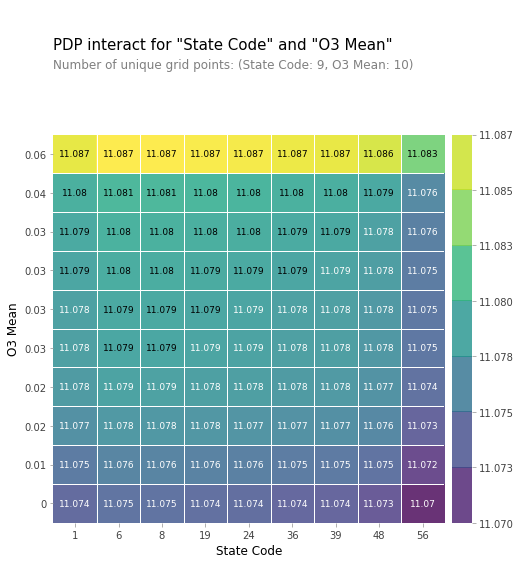

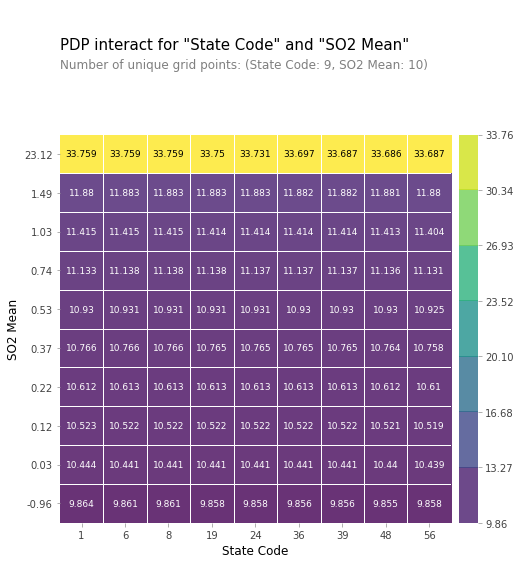

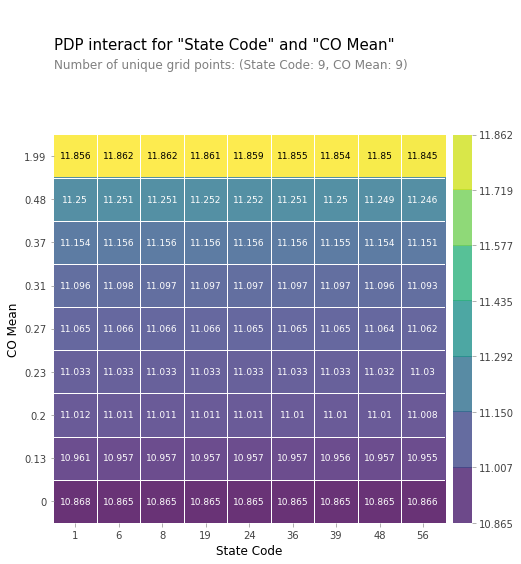

In [ ]:
#Partial Dependence Plots
factors = ['NO2 Mean', 'O3 Mean', 'SO2 Mean', 'CO Mean']

for fact in factors:
  features = ['State Code', fact]
  interact = pdp_interact(model_rf, dataset=X_val,
                        model_features = X_val.columns,
                        features = features)
  pdp_interact_plot(interact, plot_type = 'grid', feature_names = features)

Shapely plots

In [ ]:
samp = X_val.head(1)

In [ ]:
#Whats the average AQI pollutant trends for the general US?
explainer = shap.TreeExplainer(model_rf)
shap_values = explainer.shap_values(samp)

shap.initjs()
shap.force_plot(base_value= explainer.expected_value,
                shap_values = shap_values,
                features = samp)

We note our base value from our Tree based model is our predicted value if we did not know any fetures for the current output, simply the mean prediction: 
$$E[f(X)] = 15.155$$


The output value is the prediction for the observation- the first row :
$$f(x) = 3.09$$


We see from our shap plot that over the years, the pollutants have decreased over time except for O3. O3 slightly increased over the years by a marginal amount. Note that the largest drop in mean value over time is NO2.

Now let's look at the most polluted states in the US, which is California and New York.

In [20]:
#now let's look at California over the years

ca = X_train.loc[X_train['State Code'] == 6]
ca

,State Code,County Code,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI,Good_AQI
Date Local,,,,,,,,,,,,,,,,,,,
2000-01-01,6,13,14.782609,26.0,4,25,0.015542,0.029,13,25,0.636364,2.0,9,3.0,0.572222,0.8,6,9.0,1
2000-01-02,6,13,16.043478,30.0,21,28,0.015292,0.032,9,27,1.000000,2.0,5,3.0,0.520833,0.8,23,9.0,1
2000-01-03,6,13,25.521739,40.0,17,38,0.005625,0.014,8,12,2.454545,4.0,13,6.0,1.133333,1.9,23,22.0,1
2000-01-04,6,13,26.041667,44.0,17,42,0.006083,0.011,13,9,1.541667,4.0,17,6.0,1.408333,2.0,0,23.0,1
2000-01-05,6,13,23.772727,38.0,17,36,0.010500,0.022,8,19,1.681818,4.0,10,6.0,0.941667,1.7,23,19.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,6,95,14.108696,31.2,0,29,0.013083,0.020,10,19,0.909091,1.6,0,1.0,0.833333,1.5,3,17.0,1
2015-12-28,6,95,15.734783,32.3,18,30,0.010250,0.024,9,22,0.854545,2.0,22,3.0,0.591667,1.6,23,18.0,1
2015-12-29,6,95,21.213043,33.4,22,31,0.007083,0.021,9,19,1.227273,1.8,0,1.0,1.100000,1.9,2,22.0,1


In [21]:
#Let's predict for CA and fit our model
model_rf.predict(ca)

array([16.  , 17.96, 29.01, ..., 23.75, 20.99, 20.97])

In [24]:
samp = ca.head(1)
explainer = shap.TreeExplainer(model_rf)
shap_values = explainer.shap_values(samp)

shap.initjs()
shap.force_plot(base_value= explainer.expected_value,
                shap_values = shap_values,
                features = samp)

We note our base value from our Tree based model is our predicted value if we did not know any fetures for the current output, simply the mean prediction: 
$$E[f(X)] = 15.155$$


The output value is the prediction for the observation- the first row :
$$f(x) = 16.00$$


We see from our shap values that mainly CO Mean and NO2 mean push the prediction of total AQI higher whereas SO2 Mean and our binary classifier Good_AQI decreases our total predicted AQI for California.

In [ ]:
#now let's look at New York over the years

ny = X_train.loc[X_train['State Code'] == 36]
ny

,State Code,County Code,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI,Good_AQI
Date Local,,,,,,,,,,,,,,,,,,,
2000-05-05,36,5,42.500000,60.0,22,57,0.018417,0.036,10,31,8.800000,15.0,23,21.0,0.787500,1.1,23,13.0,0
2000-05-06,36,5,42.875000,82.0,20,81,0.034333,0.065,10,67,9.500000,26.0,2,37.0,1.195833,2.1,5,24.0,0
2000-05-07,36,5,29.000000,56.0,7,53,0.036583,0.069,10,80,7.041667,21.0,6,30.0,0.837500,1.3,0,15.0,1
2000-05-08,36,5,49.958333,87.0,20,86,0.027750,0.057,10,48,12.045455,26.0,6,37.0,0.916667,1.2,23,14.0,0
2000-05-09,36,5,36.619048,55.0,7,52,0.042125,0.066,10,71,9.666667,19.0,1,27.0,0.795833,1.2,0,14.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,36,81,13.920833,29.5,7,27,0.010625,0.020,23,19,0.208333,0.7,7,0.0,0.233333,0.3,7,3.0,1
2015-12-28,36,81,7.816667,13.1,20,12,0.023750,0.026,8,24,0.216667,0.7,22,0.0,0.137500,0.2,0,2.0,1
2015-12-29,36,81,17.225000,34.7,19,32,0.014250,0.023,8,21,0.279167,1.1,21,1.0,0.183333,0.4,23,5.0,1


In [ ]:
#what does our model predict for ny?

model_rf.predict(ny)

array([52.04, 53.71, 36.92, ..., 17.96, 19.  , 16.  ])

In [ ]:
samp = ny.head(1)
explainer = shap.TreeExplainer(model_rf)
shap_values = explainer.shap_values(samp)

shap.initjs()
shap.force_plot(base_value= explainer.expected_value,
                shap_values = shap_values,
                features = samp)

We note our base value from our Tree based model is our predicted value if we did not know any fetures for the current output, simply the mean prediction: 
$$E[f(X)] = 15.155$$


The output value is the prediction for the observation- the first row :
$$f(x) = 52.04$$


We see from our shap values that mainly SO2 Mean and NO2 mean push the prediction of total AQI higher for New York. Unfortunately, other variables do not largely decrease the total AQI prediction for New York.

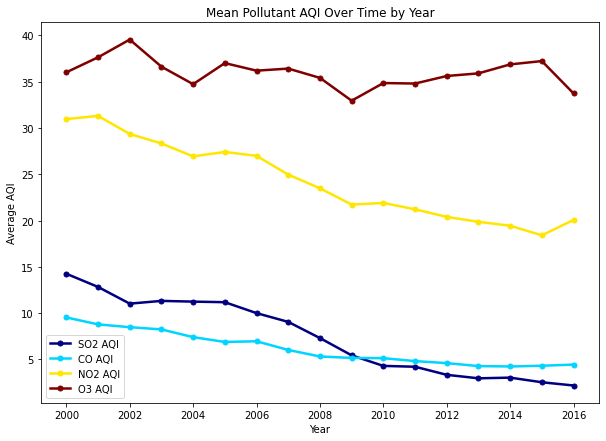

In [ ]:
f, ax = plt.subplots(figsize=[10,7])
df.groupby(df.index.year).agg({'SO2 AQI': 'mean',
                          'CO AQI': 'mean',
                          'NO2 AQI': 'mean',
                          'O3 AQI': 'mean'})\
.plot(lw=2,colormap='jet',marker='.',markersize=10, ax =ax,linewidth=2.5)
ax.set_title('Mean Pollutant AQI Over Time by Year')
ax.set(xlabel="Year", ylabel="Average AQI")
plt.show()